<h1>Machine Learning Project</h1>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import pickle

<h2>Load the datasets</h2>

In [2]:
def load_data():
    """
    Load the MNIST dataset. Reads the training and testing files and create matrices.
    :Expected return:
    train_data:the matrix with the training data
    test_data: the matrix with the data that will be used for testing
    y_train: the matrix consisting of one 
                        hot vectors on each row(ground truth for training)
    y_test: the matrix consisting of one
                        hot vectors on each row(ground truth for testing)
    """
    
    #load the train files
    df = None
    
    y_train = []

    for i in range( 10 ):
        tmp = pd.read_csv( '/Users/emiliadan/Downloads/Machine Learning/mnistdata/train%d.txt' % i, header=None, sep=" " )
        #build labels - one hot vector
        hot_vector = [ 1 if j == i else 0 for j in range(0,10) ]
        
        for j in range( tmp.shape[0] ):
            y_train.append( hot_vector )
        #concatenate dataframes by rows    
        if i == 0:
            df = tmp
        else:
            df = pd.concat( [df, tmp] )

    train_data = df.to_numpy()
    y_train = np.array( y_train )
    print(y_train)
    print(y_train.shape)
    
    #load test files
    df = None
    
    y_test = []

    for i in range( 10 ):
        tmp = pd.read_csv( '/Users/emiliadan/Downloads/Machine Learning/mnistdata/test%d.txt' % i, header=None, sep=" " )
        #build labels - one hot vector
        
        hot_vector = [ 1 if j == i else 0 for j in range(0,10) ]
        
        for j in range( tmp.shape[0] ):
            y_test.append( hot_vector )
        #concatenate dataframes by rows    
        if i == 0:
            df = tmp
        else:
            df = pd.concat( [df, tmp] )

    test_data = df.to_numpy()
    y_test = np.array( y_test )
    
    return train_data, test_data, y_train, y_test


In [3]:
X_train, X_test, y_train, y_test = load_data()


[[1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 1]]
(60000, 10)


/Users/emiliadan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]


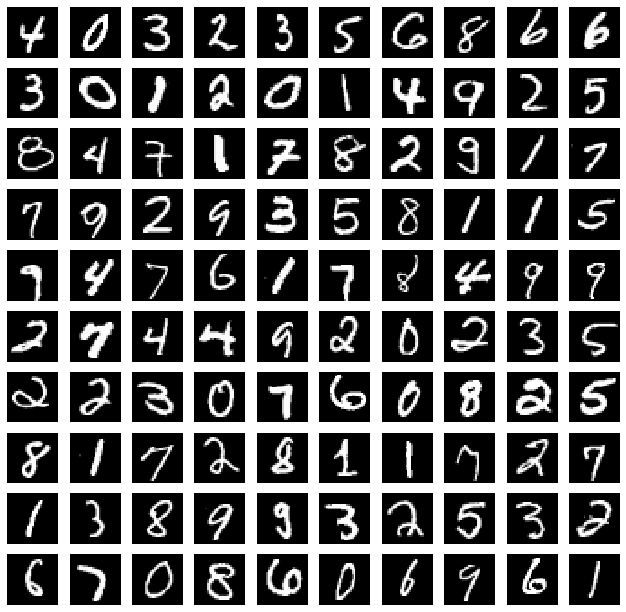

In [4]:
# plot 5 random images from the training set

n = 100
sqrt_n = int( n**0.5 )
samples = np.random.randint(X_train.shape[0], size=n)

plt.figure( figsize=(11,11) )

cnt = 0
for i in samples:
    cnt += 1
    plt.subplot( sqrt_n, sqrt_n, cnt )
    plt.subplot( sqrt_n, sqrt_n, cnt ).axis('off')
    plt.imshow( X_train[i].reshape(28,28), cmap='gray'  )

plt.show()

<h2>Normalize ,Bias, Weights</h2>

In [4]:
X_train = X_train.astype(float)/255
X_test = X_test.astype(float)/255

N, D = X_train.shape
K = y_train.shape[1] 
M = 100 #changes might be 200 or 300
#M =  hidden layer input size 

#weights
w1 = np.random.rand(M,D+1)*np.sqrt(1/(D+1)) 
w2 = np.random.rand(K,M+1)*np.sqrt(1/(M+1)) 

X_train = np.hstack( (np.ones((X_train.shape[0],1) ), X_train) )
X_test = np.hstack( (np.ones((X_test.shape[0],1) ), X_test) )


N, D = X_train.shape
K = y_train.shape[1] 
M = 100 #changes might be 200 or 300
#M =  hidden layer input size 



In [5]:
print(w1.shape)
print(w2.shape)

(100, 785)
(10, 101)


In [36]:
def softmax( x, ax=1 ):
    m = np.max( x, axis=ax, keepdims=True )#max per row
    p = np.exp( x - m )
    return ( p / np.sum(p,axis=ax,keepdims=True) )

In [37]:
def cost_grad_softmax(w1,w2,choice,x,y, lamda):
    
    
    a = x.dot(w1.T)
    zn = functions(choice,a) #we pass batched x data array and dot it with w1.T
    zn = np.hstack( (np.ones((zn.shape[0],1) ), zn) ) #bias zn0 = 1
    
    softmax_input = zn.dot(w2.T) 
    softmax_output = softmax( softmax_input )
    
   
    E = 0
   
    max_error = np.max(softmax_input,axis=1) 
    E = np.sum(y*softmax_input) - np.sum(max_error) -\
    np.sum(np.log(np.sum(np.exp(softmax_input - np.array([max_error,]*softmax_input.shape[1]).T),1)))
    E -= lamda * np.square(np.linalg.norm(w1))/2 + lamda * np.square(np.linalg.norm(w2))/2 
    
    gradEw2 = (y - softmax_output).T.dot(zn) - lamda*w2 
    gradEw1 = np.multiply((y - softmax_output).dot(w2[:,1:]),derivatives(choice,a)).T.dot(x)  - lamda* w1
    
    
    return E,gradEw2,gradEw1 
    

In [38]:
def functions(choice, a):
    if choice == 1:
        #return np.log(1.0 + np.exp(a))
        return np.log(1.0+np.exp(-a)) + a 
    elif choice == 2:
        return (np.exp(a) - np.exp(-a)) / (np.exp(a) + np.exp(-a))
    else:
        return np.cos(a)
        

In [39]:
def derivatives(choice,a):
    if choice == 1:
        return np.exp(a)/(1.0 + np.exp(a))
    elif choice == 2:
        return 1 - np.square(np.tanh(a))
    else:
        
        return -np.sin(a)

In [40]:
def ml_train(t, X, lamda, w1,w2, options,minibatch_size,choice): 
    
    """inputs :
      t: N x 1 binary output data vector indicating the two classes
      X: N x (D+1) input data vector with ones already added in the first column
      lamda: the positive regularizarion parameter
      winit: D+1 dimensional vector of the initial values of the parameters
      options: options(1) is the maximum number of iterations
               options(2) is the tolerance
               options(3) is the learning rate eta
    outputs :
      w: the trained D+1 dimensional vector of the parameters"""
    
    

    # Maximum number of iteration of gradient ascend
    _iter = options[0]

    # Tolerance
    tol = options[1]

    # Learning rate
    eta = options[2]
    
    
    
    Ewold = -np.inf
    costs = []
    length = len(X)
    
    
    for i in range( 1, _iter+1 ):
        
        
        idx = np.random.permutation(length)    
        X_train, y_train = X[idx,:],t[idx,:]
        
        for m in range(0,X_train.shape[0],minibatch_size):
        
            btchX = X_train[m:m+minibatch_size]
            btchY = y_train[m:m+minibatch_size]
        
    
            Ew,gradEw2,gradEw1 = cost_grad_softmax(w1,w2,choice,btchX,btchY, lamda)
        
            
        
            #need to update for each mini - batch
            w1 = w1 + eta * gradEw1
            w2 = w2 + eta * gradEw2
            
            if m == 0 :
                costs.append(Ew)
                
            # Break if you achieve the desired accuracy in the cost function
            if np.abs(Ew - Ewold) < tol:
                break
        

            Ewold = Ew
        
        costs.append(Ew)
            
        
        
        # Show the current cost function on screen
        if i % 50 == 0:
                print('Iteration : %d, Cost function :%f' % (i, Ew))

        

    return w1,w2, costs

In [12]:
%%time
options = [100,1e-6,0.0005]
lamda = 0.1
batch_size = 100

#choice = 1 is for the log
#choice = 2 is for the exp
#choice = 3 is for the cos

choice = 1 #change 

nw1,nw2,ncost = ml_train(y_train, X_train, lamda, w1,w2, options,batch_size,choice)   

Iteration : 50, Cost function :-19.973070
Iteration : 100, Cost function :-14.646151
CPU times: user 3min 53s, sys: 17.1 s, total: 4min 10s
Wall time: 2min 54s


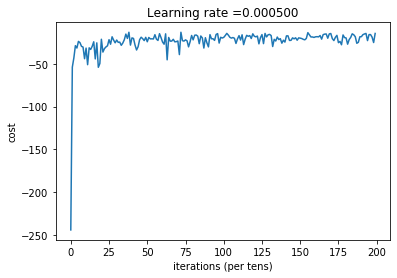

In [13]:
plt.plot(np.squeeze(ncost)) 
plt.ylabel('cost')
plt.xlabel('iterations (per tens)')

plt.title("Learning rate =" + str(format(options[2], 'f')))
plt.show()

In [35]:
def gradcheck_softmax_w2(w1,w2,choice, X, t, lamda):
    
    
    epsilon = 1e-6
    
    _list = np.random.randint(X.shape[0], size=5)
    x_sample = np.array(X[_list, :])  #sample
    t_sample = np.array(t[_list, :])
    

    #print(w2.shape)
    
    
    Ew, gradEw2,_ = cost_grad_softmax(w1,w2,choice, x_sample, t_sample, lamda)
    
    
    numGrad_w2 = np.zeros(gradEw2.shape) #10x101
   
    
    for k in range(numGrad_w2.shape[0]): #10
        for d in range(numGrad_w2.shape[1]): #101
            
            #add epsilon to the w[k,d]
            w2_tmp = np.copy(w2)
            w2_tmp[k, d] += epsilon
            e_plus, _,_ = cost_grad_softmax(w1,w2_tmp,choice, x_sample, t_sample, lamda)

            #subtract epsilon to the w[k,d]
            w2_tmp = np.copy(w2)
            w2_tmp[k, d] -= epsilon
            e_minus, _,_ = cost_grad_softmax( w1,w2_tmp,choice, x_sample, t_sample, lamda)
            
            #approximate gradient ( E[ w[k,d] + theta ] - E[ w[k,d] - theta ] ) / 2*e
            numGrad_w2[k, d] = (e_plus - e_minus) / (2 * epsilon)
    
    
    
    return  gradEw2, numGrad_w2

In [15]:
%%time
lamda = 0.1
choice = 1
gradE2,numGrad2 = gradcheck_softmax_w2(w1,w2,choice, X_train, y_train, lamda)
print( "The difference estimate for gradient of w2 is : ", np.max(np.abs(gradE2 - numGrad2)) )

The difference estimate for gradient of w2 is :  9.298921632705515e-09
CPU times: user 1.48 s, sys: 19.8 ms, total: 1.5 s
Wall time: 811 ms


In [16]:
pd.DataFrame( gradE2 )

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,100
0,-1.002101,-2.483895,-2.350554,-2.328939,-2.208034,-2.204141,-2.393043,-2.479036,-2.371959,-2.494383,...,-2.340481,-2.261293,-2.229246,-2.334690,-2.322394,-2.237691,-2.314327,-2.354835,-2.319570,-2.292128
1,-0.428466,-1.038517,-0.986139,-0.974568,-0.925478,-0.922525,-1.003833,-1.033113,-0.993791,-1.040690,...,-0.975452,-0.947211,-0.939768,-0.972427,-0.967532,-0.934071,-0.966758,-0.983811,-0.965879,-0.958042
2,2.900084,8.148601,7.499183,7.521672,6.979264,7.104822,7.684402,8.137565,7.698110,8.135525,...,7.495890,7.281278,7.024043,7.414339,7.397353,7.174721,7.473304,7.554203,7.604825,7.294838
3,-0.253483,-0.599102,-0.574833,-0.570193,-0.540376,-0.539294,-0.585587,-0.602198,-0.574923,-0.601458,...,-0.567967,-0.553464,-0.545573,-0.572334,-0.571697,-0.545088,-0.562762,-0.574577,-0.563269,-0.557398
4,-0.319171,-0.765026,-0.722509,-0.717468,-0.676757,-0.682142,-0.736383,-0.765011,-0.730892,-0.765375,...,-0.718531,-0.696364,-0.685241,-0.718247,-0.711408,-0.687711,-0.707407,-0.720376,-0.712678,-0.708947
5,-1.216509,-3.050795,-2.882802,-2.852861,-2.699323,-2.707232,-2.935045,-3.047775,-2.901094,-3.054733,...,-2.863823,-2.768578,-2.736537,-2.858006,-2.848626,-2.741287,-2.840901,-2.881919,-2.850240,-2.809094
6,0.492839,0.399843,0.433250,0.518315,0.553760,0.432822,0.547161,0.433804,0.536059,0.374251,...,0.506548,0.446831,0.469311,0.531090,0.413940,0.454435,0.382329,0.495347,0.344522,0.479374
7,0.669381,1.505253,1.602177,1.384089,1.408540,1.411400,1.456854,1.468533,1.353482,1.575614,...,1.457433,1.419487,1.554070,1.503800,1.604512,1.426199,1.513705,1.487151,1.428497,1.495438
8,-0.478678,-1.176237,-1.113536,-1.103969,-1.044452,-1.047727,-1.132858,-1.174879,-1.118388,-1.170621,...,-1.106711,-1.071985,-1.062275,-1.107632,-1.101449,-1.053019,-1.096564,-1.108731,-1.090709,-1.087620
9,-0.412562,-1.000698,-0.943756,-0.940309,-0.893387,-0.889067,-0.963882,-0.993778,-0.950910,-1.001819,...,-0.939750,-0.907334,-0.905627,-0.938179,-0.933353,-0.900391,-0.927404,-0.948415,-0.927480,-0.927735


In [24]:
def gradcheck_softmax_w1(w1,w2,choice, X, t, lamda):
    
    
    epsilon = 1e-6
    
    _list = np.random.randint(X.shape[0], size=5)
    x_sample = np.array(X[_list, :])
    t_sample = np.array(t[_list, :])
    
    
    Ew,_,gradEw1 = cost_grad_softmax(w1,w2,choice, x_sample, t_sample, lamda)
    
    numGrad_w1 = np.zeros(gradEw1.shape) 
  
    for k in range(numGrad_w1.shape[0]):  #100x785
        for d in range(numGrad_w1.shape[1]):
            
            #add epsilon to the w[k,d]
            w1_tmp = np.copy(w1)
            w1_tmp[k, d] += epsilon
            e_plus, _,_ = cost_grad_softmax(w1_tmp,w2,choice, x_sample, t_sample, lamda)

            #subtract epsilon to the w[k,d]
            w1_tmp = np.copy(w1)
            w1_tmp[k, d] -= epsilon
            e_minus, _,_ = cost_grad_softmax( w1_tmp,w2,choice, x_sample, t_sample, lamda)
            
            #approximate gradient ( E[ w[k,d] + theta ] - E[ w[k,d] - theta ] ) / 2*e
            numGrad_w1[k, d] = (e_plus - e_minus) / (2 * epsilon)
    
    return gradEw1,numGrad_w1

In [48]:
%%time
lamda = 0.1
choice = 1
gradE1,numGrad1 = gradcheck_softmax_w1(w1,w2,choice, X_train, y_train, lamda)
print( "The difference estimate for gradient of w1 is : ", np.max(np.abs(gradE1 - numGrad1)) )

The difference estimate for gradient of w1 is :  1.659720030161571e-08
CPU times: user 1min 54s, sys: 581 ms, total: 1min 55s
Wall time: 58.6 s


In [49]:
pd.DataFrame( gradE1 )

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,0.048306,-0.002981,-0.000394,-0.001005,-0.001043,-0.001309,-0.000524,-0.000911,-0.002070,-0.003202,...,-0.000163,-0.002993,-0.003120,-0.000891,-0.003312,-0.001498,-0.003317,-0.000977,-0.002858,-0.000830
1,-0.046716,-0.000461,-0.001141,-0.002302,-0.002133,-0.002506,-0.000612,-0.000526,-0.001452,-0.001839,...,-0.001013,-0.001538,-0.000363,-0.002145,-0.001352,-0.001650,-0.000500,-0.002236,-0.002807,-0.001697
2,-0.010821,-0.002108,-0.001711,-0.002006,-0.002032,-0.000887,-0.002423,-0.001909,-0.003373,-0.003285,...,-0.001494,-0.001104,-0.001371,-0.002061,-0.000603,-0.001263,-0.000983,-0.002535,-0.000583,-0.002383
3,-0.029019,-0.000947,-0.000228,-0.001822,-0.000764,-0.002054,-0.000642,-0.003330,-0.003545,-0.002943,...,-0.002512,-0.003009,-0.000291,-0.002185,-0.000526,-0.002836,-0.003046,-0.002496,-0.000659,-0.002558
4,-0.109897,-0.001871,-0.002074,-0.001575,-0.002876,-0.001115,-0.001447,-0.000570,-0.002791,-0.001464,...,-0.002495,-0.001725,-0.000263,-0.001666,-0.002201,-0.001909,-0.001633,-0.002783,-0.002137,-0.003563
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,-0.082294,-0.000127,-0.000171,-0.002572,-0.000420,-0.000673,-0.000099,-0.001602,-0.001410,-0.000795,...,-0.000891,-0.001875,-0.001201,-0.002305,-0.001041,-0.002797,-0.001894,-0.000878,-0.000087,-0.001406
96,0.106934,-0.002576,-0.001217,-0.000485,-0.002568,-0.001483,-0.003448,-0.000933,-0.000747,-0.001140,...,-0.001448,-0.000912,-0.000036,-0.000535,-0.000863,-0.000149,-0.000121,-0.003277,-0.000352,-0.001506
97,0.052284,-0.002613,-0.002774,-0.003078,-0.000206,-0.000377,-0.003250,-0.000255,-0.002108,-0.001739,...,-0.003448,-0.000343,-0.003054,-0.003070,-0.000966,-0.003073,-0.002695,-0.003385,-0.002828,-0.003244
98,0.004791,-0.001071,-0.003354,-0.002130,-0.001546,-0.003386,-0.001883,-0.002314,-0.003034,-0.001478,...,-0.000885,-0.002163,-0.002922,-0.001436,-0.001992,-0.000953,-0.000563,-0.003193,-0.000885,-0.003321


In [45]:
def ml_test(w1,w2, X_test,choice):
    a = X_test.dot(w1.T)
    
    zn = functions(choice,a) 
    zn = np.hstack( (np.ones((zn.shape[0],1) ), zn) )
    softmax_input = zn.dot(w2.T) 
    ytest = softmax( softmax_input )
    
    # Hard classification decisions
    ttest = np.argmax(ytest, 1)
    return ttest

In [15]:
pred = ml_test(nw1,nw2, X_test,choice)

In [16]:
np.mean( pred == np.argmax(y_test,1) )


0.9721

/Users/emiliadan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]


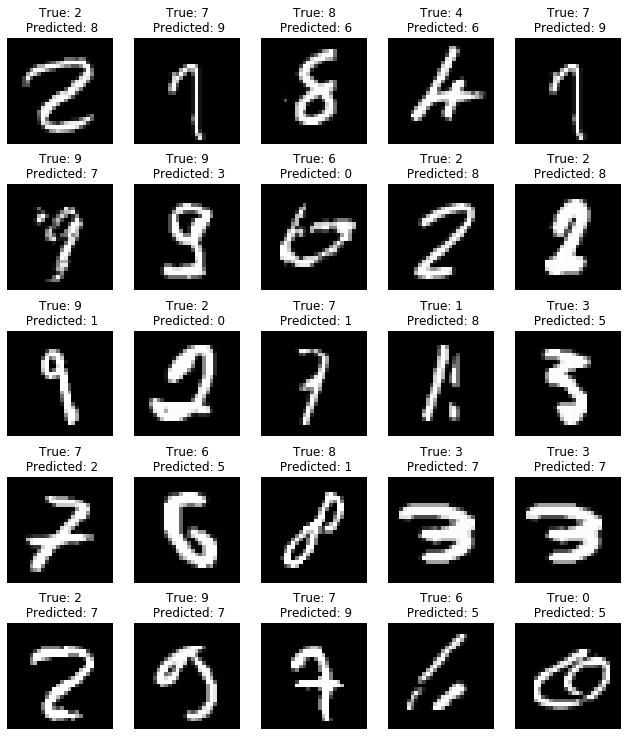

In [165]:
faults = np.where(np.not_equal(np.argmax(y_test,1),pred))[0]
# plot n misclassified examples from the Test set
n = 25
samples = np.random.choice(faults, n)
sqrt_n = int( n ** 0.5 )

plt.figure( figsize=(11,13) )

cnt = 0
for i in samples:
    cnt += 1
    plt.subplot( sqrt_n, sqrt_n, cnt )
    plt.subplot( sqrt_n, sqrt_n, cnt ).axis('off')
    plt.imshow( X_test[i,1:].reshape(28,28)*255, cmap='gray' )
    plt.title("True: "+str(np.argmax(y_test,1)[i])+ "\n Predicted: "+ str(pred[i]))
    
plt.show()

/Users/emiliadan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]


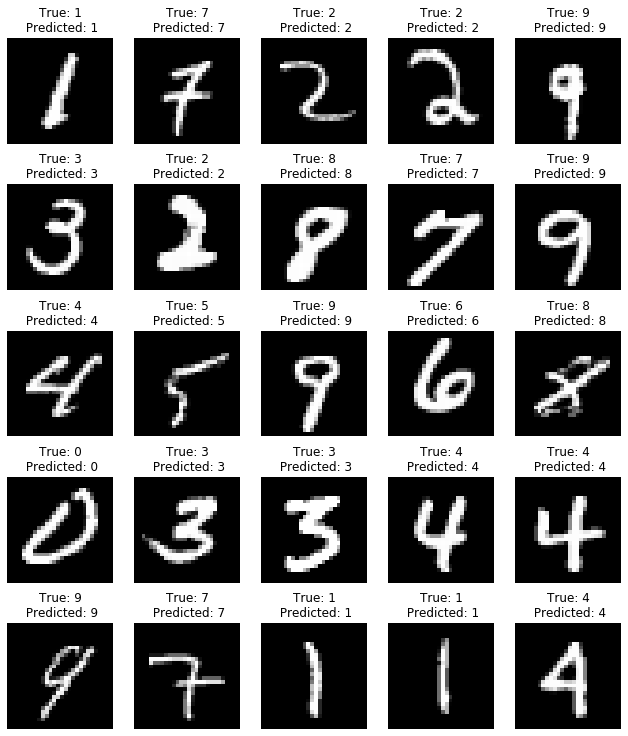

In [166]:
trues = np.where(np.equal(np.argmax(y_test,1),pred))[0]
# plot n misclassified examples from the Test set
n = 25
samples = np.random.choice(trues, n)
sqrt_n = int( n ** 0.5 )

plt.figure( figsize=(11,13) )

cnt = 0
for i in samples:
    cnt += 1
    plt.subplot( sqrt_n, sqrt_n, cnt )
    plt.subplot( sqrt_n, sqrt_n, cnt ).axis('off')
    plt.imshow( X_test[i,1:].reshape(28,28)*255, cmap='gray' )
    plt.title("True: "+str(np.argmax(y_test,1)[i])+ "\n Predicted: "+ str(pred[i]))
    
plt.show()

In [53]:
def unpickle(file):
    #import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='latin1')
    return dict

In [177]:
def load_data_cifar():
    
    
    x_train = []
    y_train = []
    hot_vec = []
    #temp = unpickle('/Users/emiliadan/Downloads/cifar-10/data_batch_1')
   
    for i in range(5):
        
        num = i+1
        temp = unpickle('/Users/emiliadan/Downloads/cifar-10/data_batch_%d' % num)
        
        
        y_train = temp.get('labels')
        
        x_train.append(temp.get('data'))
        for m in range(len(y_train)):
            hot_vectors = [ 1 if y_train[m] == j else 0 for j in range(0,10) ]
            
            hot_vec.append(hot_vectors)
        
    y_train_cifar = np.array(hot_vec)
    
    
    x_train_cifar = np.concatenate( x_train, axis=0 )
    reshaped_x_train = x_train_cifar.reshape((len(x_train_cifar),3,32,32)).transpose(0,2,3,1)
    reshaped_train = np.mean(reshaped_x_train,axis=3)
    reshaped_train = np.reshape(reshaped_train, (reshaped_train. shape[0], - 1))
    

    x_test = []
    y_test = []
    hot_vec2 = []
    temp2 = unpickle('/Users/emiliadan/Downloads/cifar-10/test_batch')
    x_test.append(temp2.get('data'))
    x_test = np.concatenate( x_test, axis=0 )
    reshaped_x_test = x_test.reshape((len(x_test),3,32,32)).transpose(0,2,3,1)
    reshaped_test = np.mean(reshaped_x_test,axis=3)
    reshaped_test = np.reshape(reshaped_test, (reshaped_test. shape[0], - 1))
    
    for m in range(len(x_test)):
            hot_vectors = [ 1 if temp2.get('labels')[m] == j else 0 for j in range(0,10) ]
            hot_vec2.append(hot_vectors)
    
    y_test = np.array(hot_vec2)
    
    return x_train_cifar,y_train_cifar,x_test,y_test,reshaped_x_train,reshaped_train,reshaped_test

In [178]:
x1,y1,x2,y2,reshaped_x_train,reshaped_train,reshaped_test = load_data_cifar()

/Users/emiliadan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':


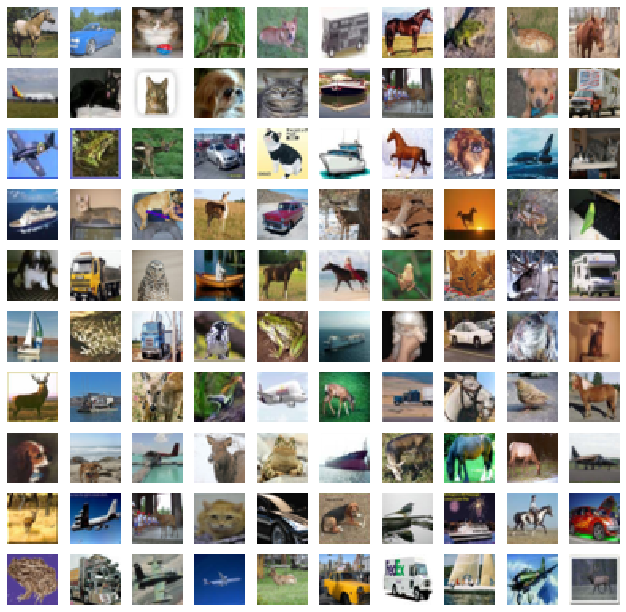

In [171]:
# plot 5 random images from the training set
n = 100
sqrt_n = int( n**0.5 )
samples = np.random.randint(x1.shape[0], size=n)

plt.figure( figsize=(11,11) )

cnt = 0
for i in samples:
    cnt += 1
    plt.subplot( sqrt_n, sqrt_n, cnt )
    plt.subplot( sqrt_n, sqrt_n, cnt ).axis('off')
    plt.imshow( reshaped_x_train[i], cmap='gray'  )
    #plt.imshow(reshaped_train[i].reshape(32,32),cmap='gray')

plt.show()

In [179]:
#X_train = x1.astype(float)/255 #coloured
#X_test = x2.astype(float)/255

X_train = reshaped_train.astype(float)/255 #not coloured
X_test = reshaped_test.astype(float)/255

N, D = X_train.shape
K = 10 
M = 100 #changes might be 200 or 300


w1c = np.random.rand(M,D+1)*np.sqrt(1/(D+1)) 
w2c = np.random.rand(K,M+1)*np.sqrt(1/(M+1)) 
print(w1c.shape,w2c.shape)

X_train = np.hstack( (np.ones((X_train.shape[0],1) ), X_train) )
X_test = np.hstack( (np.ones((X_test.shape[0],1) ), X_test) )

N, D = X_train.shape

(100, 1025) (10, 101)


In [173]:
%%time
lamda = 0.1
choice = 1
gradEw2,numGrad2 = gradcheck_softmax_w2(w1c,w2c,choice, X_train, y1, lamda)
print( "The difference estimate for gradient of w2 is : ", np.max(np.abs(gradEw2 - numGrad2)) )


The difference estimate for gradient of w2 is :  2.537350596298893e-08
CPU times: user 1.88 s, sys: 85.2 ms, total: 1.96 s
Wall time: 1.02 s


In [208]:
%%time
lamda = 0.1
choice = 1
gradEw1,numGradw1 = gradcheck_softmax_w1(w1c,w2c,choice, X_train, y1, lamda)
print( "The difference estimate for gradient of w1 is : ", np.max(np.abs(gradEw1 - numGradw1)) )

KeyboardInterrupt: 

In [180]:
%%time
options = [100,1e-6,0.005]
lamda = 0.1
batch_size = 100
choice = 1
updated_w1,updated_w2,costs = ml_train(y1, X_train, lamda, w1c,w2c, options,batch_size,choice)

Iteration : 50, Cost function :-195.576723
Iteration : 100, Cost function :-200.240755
CPU times: user 2min 19s, sys: 12.4 s, total: 2min 31s
Wall time: 1min 19s


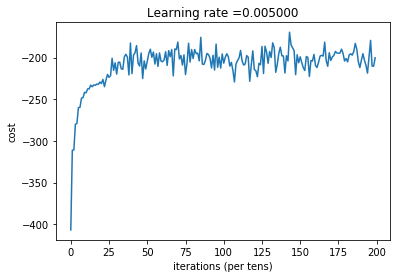

In [181]:
plt.plot(np.squeeze(costs)) 
plt.ylabel('cost')
plt.xlabel('iterations (per tens)')

plt.title("Learning rate =" + str(format(options[2], 'f')))
plt.show()

In [182]:
pred = ml_test(updated_w1,updated_w2, X_test,choice)
print('Accuracy is:',np.mean( pred == np.argmax(y2,1) ))

Accuracy is: 0.2872


/Users/emiliadan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]


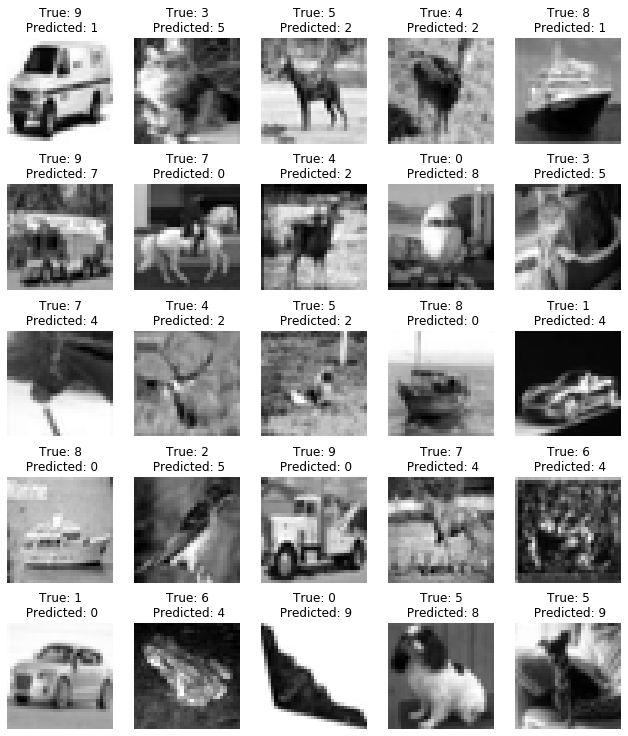

In [183]:
faults = np.where(np.not_equal(np.argmax(y2,1),pred))[0]
# plot n misclassified examples from the Test set
n = 25
samples = np.random.choice(faults, n)
sqrt_n = int( n ** 0.5 )

plt.figure( figsize=(11,13) )

cnt = 0
for i in samples:
    cnt += 1
    plt.subplot( sqrt_n, sqrt_n, cnt )
    plt.subplot( sqrt_n, sqrt_n, cnt ).axis('off')
    plt.imshow( X_test[i,1:].reshape(32,32)*255, cmap='gray' )
    plt.title("True: "+str(np.argmax(y2,1)[i])+ "\n Predicted: "+ str(pred[i]))
    
plt.show()

/Users/emiliadan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]


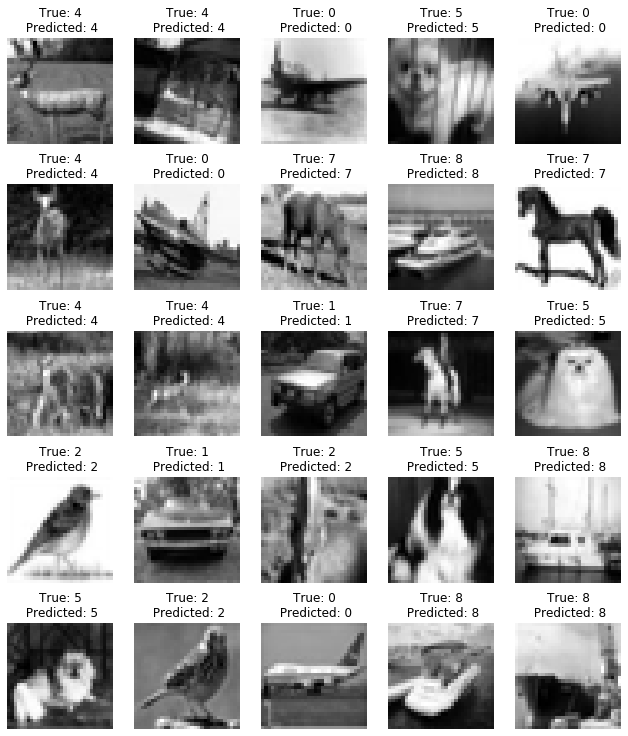

In [184]:
trues = np.where(np.equal(np.argmax(y2,1),pred))[0]
# plot n misclassified examples from the Test set
n = 25
samples = np.random.choice(trues, n)
sqrt_n = int( n ** 0.5 )

plt.figure( figsize=(11,13) )

cnt = 0
for i in samples:
    cnt += 1
    plt.subplot( sqrt_n, sqrt_n, cnt )
    plt.subplot( sqrt_n, sqrt_n, cnt ).axis('off')
    plt.imshow( X_test[i,1:].reshape(32,32)*255, cmap='gray' )
    plt.title("True: "+str(np.argmax(y2,1)[i])+ "\n Predicted: "+ str(pred[i]))
    
plt.show()